In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import os
import timm

from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
from torchvision.io import read_image
from torchvision.io import ImageReadMode
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

In [2]:
class LeavesDataset(torch.utils.data.Dataset):
    def __init__(self, transforms, path="../data/A1"):
        self.path = path
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = [x for x in os.listdir(path) if x.endswith("_rgb.png")]
        self.masks = [x for x in os.listdir(path) if x.endswith("_label.png")]
        self.cnt = 0

    def __getitem__(self, idx):
        # load images and masks
        img_path = self.path + "/" + self.imgs[idx]
        mask_path = self.path + "/" + self.masks[idx]
        img = read_image(img_path,ImageReadMode.RGB)
        mask = read_image(mask_path)
        # instances are encoded as different colors
        obj_ids = torch.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        # split the color-encoded mask into a set
        # of binary masks
        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)

        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)

        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        # check boxes area is not zero
        boxes = boxes[area > 0]
        labels = labels[area > 0]
        masks = masks[area > 0]
        area = area[area > 0]
        iscrowd = np.zeros((len(boxes),), dtype=np.int64)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        if self.cnt == 0:
            print(img.shape)
            self.cnt += 1
            
        return img, target

    def __len__(self):
        return len(self.imgs)

In [3]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection import MaskRCNN
from torchvision.models import ResNet101_Weights, ResNet152_Weights, ResNet18_Weights
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone, BackboneWithFPN


def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained on COCO
    # sample 1
    # model = torchvision.models.detection.maskrcnn_resnet50_fpn() 
    # sample 2
    backbone = resnet_fpn_backbone('resnet18', weights=ResNet18_Weights.DEFAULT, trainable_layers=4)
    # sample 3 (not working)
    # backbone = BackboneWithFPN(
    #     backbone=MyBackbone(),
    #     out_channels=MyBackbone().out_channels,
    # )
    model = MaskRCNN(backbone, num_classes=num_classes)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 512
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(
        in_features_mask,
        hidden_layer,
        num_classes
    )

    return model

In [4]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [5]:
import utils


model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = LeavesDataset(get_transform(train=True), path="../data/A1")
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]


torch.Size([3, 530, 500])


In [6]:
targets[0]

{'boxes': tensor([[200., 219., 227., 245.],
         [230., 270., 273., 330.],
         [243., 226., 301., 240.],
         [241., 237., 309., 268.],
         [170., 252., 196., 262.],
         [140., 255., 218., 304.],
         [217., 243., 247., 270.],
         [107., 196., 205., 240.],
         [226., 225., 244., 244.],
         [178., 116., 229., 220.],
         [222., 140., 263., 182.],
         [138., 229., 214., 257.],
         [243., 184., 320., 234.],
         [225., 157., 262., 225.]]),
 'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          ...,
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0],
          [0, 0, 0,  ..., 0, 0, 0]],
 
         [[0, 0, 0,  .

In [7]:
output = model(images, targets)  # Returns losses and detections
print(output)

{'loss_classifier': tensor(2.4699, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.4036, grad_fn=<DivBackward0>), 'loss_objectness': tensor(2.1211, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0674, grad_fn=<DivBackward0>)}


In [8]:
# For inference
model.eval()
x = [torch.rand(3, 224, 224), torch.rand(3, 224, 224)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


In [9]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = LeavesDataset(get_transform(train=True))
dataset_test = LeavesDataset(get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-10])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-10:])

# define training and validation data loaders
data_loader = DataLoader(
    dataset,
    batch_size=2,
    shuffle=True,
    collate_fn=utils.collate_fn
)

data_loader_test = DataLoader(
    dataset_test,
    batch_size=1,
    shuffle=False,
    collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

print(model)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
print(f"Parameters size: {sum(p.numel() for p in model.parameters()) * 4 / 1024 / 1024} MB")
optimizer = torch.optim.SGD(
    params,
    lr=0.005,
    momentum=0.9,
    weight_decay=0.0005
)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(
    optimizer,
    step_size=3,
    gamma=0.1
)

num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

c:\Program Files\Python311\Lib\site-packages\torchvision\models\_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(

torch.Size([12])
torch.Size([0, 530, 500])


c:\Program Files\Python311\Lib\site-packages\torchvision\utils.py:303: UserWarning: masks doesn't contain any mask. No mask was drawn
  warnings.warn("masks doesn't contain any mask. No mask was drawn")


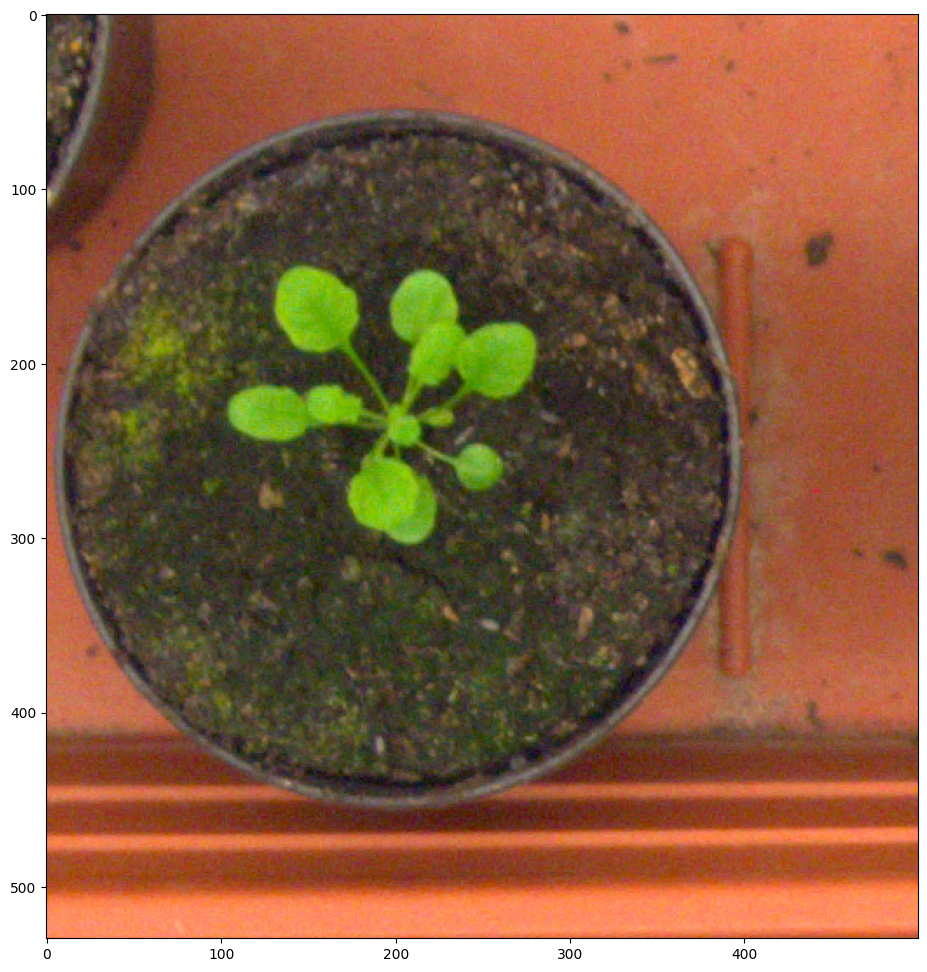

In [10]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image("../data/A1/plant002_rgb.png", ImageReadMode.RGB)
labels = read_image("../data/A1/plant002_label.png")
labels_unique = torch.unique(labels)
print(labels_unique.shape)
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]

masks = (pred["masks"] > 0.7).squeeze(1)
print(masks.shape)
image = draw_segmentation_masks(image, masks[:labels_unique.shape[0]-3])


plt.figure(figsize=(12, 12))
plt.imshow(image.permute(1, 2, 0))